<img src = "./bgsedsc_0.jpg">
$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bxi}{\boldsymbol \xi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\bw}{\boldsymbol{w}}$
$\newcommand{\balpha}{\boldsymbol{\alpha}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

# Project: Decision Trees


## Programming project: real estate assesment evaluation

Home valuation is key in real estate industry, and also the basis for mortgages in credit sector. Here we have to predict the estimated value of a property.


Data (*Regression_Supervised_Train_reduced.csv*) consist of a list of features plus the resulting $parcelvalue$, described in *Case_data_dictionary.xlsx* file. Each row corresponds to a particular home valuation, and $transactiondate$ is the date when the property was effectively sold. Properties are defined by $lotid$, but be aware that one property can be sold more than once (it's not the usual case). Also notice that some features are sometime empty, your model has to deal with it.

Note that you don't have to use $totaltaxvalue$, $buildvalue$ or $landvalue$, because they are closely correlated with the final value to predict.

+ Using this data build a predictive model for $parcelvalue$. Should be one belonging to the decision trees family of models (random forest, adaboost, gbm, xgboost, etc.).
+ Try a first quick implementation, then try to optimize hyperparameters
+ If you have computational problems, try in-class a first version with half of the observations. Remember to paralellize when possible (*n_jobs* parameter).
+ For this analysis there is an extra test dataset. Once your code is submitted we will run a competition to see how you score in the test data. Hence have prepared also the necessary script to compute the MSE estimate on the test data once released.
+ Bonus: Try an approach to fill NA without removing features or observations, and check improvements.
+ Extra bonus: Try to do a final model that as an ensemble of different decision trees models (e.g. random forest, xgboost, GBM ...), and even including models from another families (SVM, kNN).


You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. Report missing data
2. As a simplified initial version, get rid of *missing data* by:
    + Removing features that have more than 40% of missing data
    + After that, removing observations that have missing data
3. Create *dummy variables* for relevant categorical features
4. *Build* your model and test it on the same input data.
5. Assess expected accuracy using *cross-validation*
6. Try to assess variable *importance*
7. Prepare the code to *run* on a new input file and be able to report accuracy, following same preparation steps (missing data, dummies, etc)

You may want to iterate to refine some of these steps once you get performance results in step 5.

**Warning**: Please, to proceed to step 7, first *dump* your model to a file, and load it again from there. Then, remember to share with me not only the notebook, but also the dump file. Here you have an example using package *pickle*.

```python
    # generate model
    my_model= SVC(C=100, probability=True, gamma='scale')
    my_model.fit(xtrain,ytrain)
    
    # save model
    filename = 'stacking_model.sav'
    pickle.dump(my_model, open(filename, 'wb'))

    # load the model from disk and use it
    loaded_model = pickle.load(open(filename, 'rb'))
    loaded_model.predict_proba(xtest)

```

In [21]:
#Install packages on Amazon EC2 instance
import sys
!{sys.executable} -m pip install category_encoders mlens xgboost

In [22]:
%matplotlib inline
import matplotlib.pylab as plt

import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from math import floor, ceil
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix
from sklearn import preprocessing
from matplotlib.pyplot import figure
from sklearn.metrics import make_scorer
from scipy.stats import skew
import math
import random
from category_encoders.binary import BinaryEncoder
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import r2_score
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

# Some base models
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection  import ParameterGrid
from sklearn import preprocessing

import mlens
from mlens.visualization import corrmat
from mlens.ensemble import SuperLearner

import pickle

SEED=12345
random.seed(1234)

In [23]:
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          table=True,
                          display_all_params=True):

    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_


    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')
    scores_df = scores_df[scores_df.columns.drop(list(scores_df.filter(regex='time')))] #drop time parameters

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    if table:
        display(scores_df \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()

# Overall Approach

I will first train a Gradient Boosting model and assess the performance of this model. Then, I will build an ensemble, by finding the optimal parameters for various models and then using the optimized models in the ensemble. 

## Step 1: Read data, report missing data

In [24]:
dataset = pd.read_csv("./Data/Regression_Supervised_Train_reduced.csv")
dataset.head

<bound method NDFrame.head of           lotid  logerror transactiondate  aircond  style  basement  numbath  \
0      17214744       NaN             NaN      NaN    NaN       NaN      2.0   
1      12018724       NaN             NaN      1.0    NaN       NaN      2.0   
2      11306699       NaN             NaN      1.0    NaN       NaN      3.0   
3      11047729       NaN             NaN      1.0    NaN       NaN      2.0   
4      17174848       NaN             NaN      NaN    NaN       NaN      3.0   
...         ...       ...             ...      ...    ...       ...      ...   
24750  11633053       NaN             NaN      1.0    NaN       NaN      3.0   
24751  10751511       NaN             NaN      1.0    NaN       NaN      2.0   
24752  10719915       NaN             NaN      NaN    NaN       NaN      2.0   
24753  11639212       NaN             NaN      1.0    NaN       NaN      5.0   
24754  17273307       NaN             NaN      NaN    NaN       NaN      2.0   

       nu

Text(0, 0.5, 'Pctg missing data')

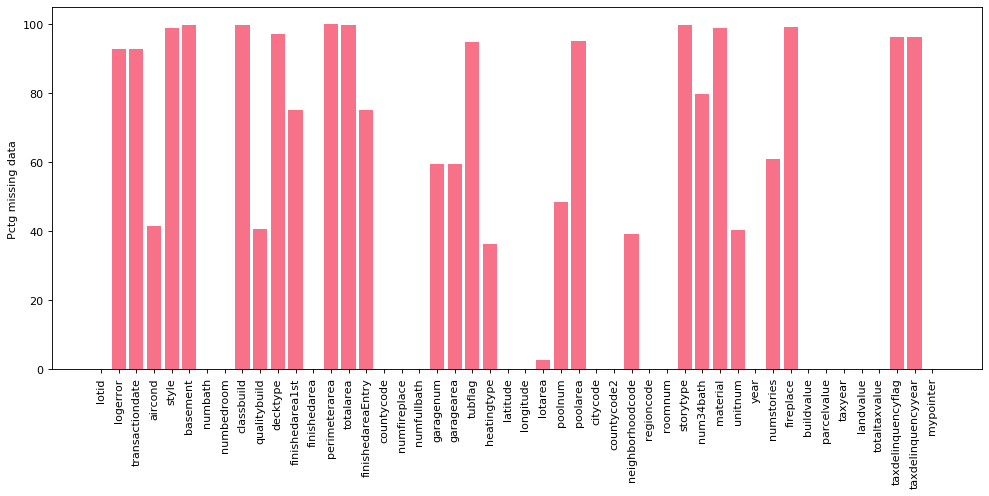

In [25]:
#Report missing data

figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
Nulls= dataset.isnull().sum()
plt.xticks(rotation='vertical')
plt.bar(Nulls.index, 100*Nulls.values/len(dataset.index))
plt.ylabel('Pctg missing data')

## Step 2: Remove features with missing data, and then impute where possible

I will remove the features with too much missing data (more than 40%), since I would not trust an imputation on these features. Then, I will use an Iterative Imputer to fill in the columns with less than 40% missing data. 

In [26]:
#Drop columns required by instructions
dataset2 = dataset.drop(['totaltaxvalue','buildvalue','landvalue'], axis=1)

#Drop columns that are not useful
dataset3 = dataset2.drop(['lotid','mypointer','countycode2', 'neighborhoodcode','regioncode'], axis=1)

#Drop columns with too much missing data
dataset4 = dataset3.dropna(axis=1, thresh=round(dataset.shape[0]*0.6))

Nulls= dataset4.isnull().sum()
any_missing = 100*Nulls.values/len(dataset4.index)>0
col_indices = [any_missing[i]*i for i in range(len(dataset4.columns))]

col_impute = []
for i in col_indices:
    if i != 0:
        col_impute.append(dataset4.columns[i])

In [27]:
col_impute

['finishedarea', 'numfullbath', 'heatingtype', 'lotarea', 'citycode', 'year']

I will split these features into continuous and categorical variables in order to use the appropriate imputers.

In [28]:
col_impute_reg = ['finishedarea','lotarea','year']
col_impute_class = ['numfullbath', 'heatingtype','citycode']

In [29]:
my_estimator1 = KNeighborsRegressor(n_neighbors=2)

dataset5 = dataset4.copy()
dataset5 = dataset5.drop('parcelvalue', axis=1)
dataset5 = dataset5.drop(col_impute_class, axis=1)

columns_without_classimp = dataset5.columns

# Imputation
cont_imputer=IterativeImputer(random_state=0, estimator=my_estimator1, max_iter=30,add_indicator=True)
cont_imputer.fit(dataset5)
dataset5=cont_imputer.transform(dataset5)

dataset6 = pd.concat([pd.DataFrame(dataset5[:,:11]), dataset4[col_impute_class]], axis=1)

In [30]:
my_estimator2 = KNeighborsClassifier(n_neighbors=2)

# Imputation
cat_imputer=IterativeImputer(random_state=0, estimator=my_estimator2, max_iter=30,add_indicator=True)
cat_imputer.fit(dataset6)
dataset6=cat_imputer.transform(dataset6)

dataset7=pd.DataFrame(dataset6[:,:14])

In [31]:
col_titles = list(columns_without_classimp) + col_impute_class
dataset7.columns = col_titles

In [32]:
#Check for any missing data
dataset7.isnull().sum()

numbath         0
numbedroom      0
finishedarea    0
countycode      0
numfireplace    0
latitude        0
longitude       0
lotarea         0
roomnum         0
year            0
taxyear         0
numfullbath     0
heatingtype     0
citycode        0
dtype: int64

In [68]:
predummy_features = dataset7.columns

## Step 3: Transforming features

I will use two types of encoding for the categorical features. For countycode, since there are only 3 categories, I will use one-hot encoding. For heatingtype and citycode, there are many categories, so I will use a Binary Encoder. I will also engineer finishedareasq as the square of the finishedarea variable and take the log of parcelvalue as the y variable. 

In [33]:
X_pretrain = dataset7
y_train = dataset4["parcelvalue"]

dummy_cols = ['citycode','countycode','heatingtype']

for col in dummy_cols:
    X_pretrain[col] = X_pretrain[col].astype(str)
    
city_encoder = BinaryEncoder()
X_pretrain = pd.concat([X_pretrain, city_encoder.fit_transform(X_pretrain['citycode'])], axis=1)

heating_encoder = BinaryEncoder()
X_pretrain = pd.concat([X_pretrain, heating_encoder.fit_transform(X_pretrain['heatingtype'])], axis=1)

X_pretrain = pd.concat([X_pretrain, pd.get_dummies(X_pretrain['countycode'], drop_first=True, prefix='county')], axis=1)

#Add terms that are more relevant
X_pretrain['finishedareasq'] = X_pretrain['finishedarea']**2

X_pretrain = X_pretrain.drop(dummy_cols, axis=1)

features = X_pretrain.columns
#Apply log to y to reduce skewness
y_train = pd.Series([math.log(i) for i in y_train])

## Step 4: Build your model and get predictions

First, I will train a Gradient Boosting Regressor and get the predictions from the test set to assess its accuracy. Then, I will train a Random Forest Regressor, KNN Regressor and SVR separately and get the optimal parameters for each model. Finally, I will use these models to build an ensemble using an Extra Trees Regressor. 

In [34]:
#I will do a train-test split in order to assess the expected accuracy of the ensemble that I will build later
X_pretrain, X_pretest, y_train, y_test = train_test_split(X_pretrain, y_train, test_size=0.1, random_state=SEED)

In [35]:
#Scale data
scaler = preprocessing.StandardScaler().fit(X_pretrain)
X_train = pd.DataFrame(scaler.transform(X_pretrain))
X_test = pd.DataFrame(scaler.transform(X_pretest))

In [36]:
MyTree = GradientBoostingRegressor()
grid_values = {'n_estimators':[100, 125, 150],
               'learning_rate':[0.1, 0.3, 0.5],
               'loss':['ls','lad','huber']}
grid_tree_acc = GridSearchCV(MyTree, param_grid = grid_values,scoring = 'neg_mean_squared_error', cv=5, n_jobs = -1)
grid_tree_acc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                

Best n_estimators parameter : 125
Best learning_rate parameter : 0.3
Best loss function : ls
best parameters: {'learning_rate': 0.3, 'loss': 'ls', 'n_estimators': 125}
best score:      -0.28155 (+/-0.00800)


,param_learning_rate,param_loss,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.3,ls,125,"{'learning_rate': 0.3, 'loss': 'ls', 'n_estima...",-0.276094,-0.289638,-0.272189,-0.292489,-0.277327,-0.281547,0.008004,1
11,0.3,ls,150,"{'learning_rate': 0.3, 'loss': 'ls', 'n_estima...",-0.276271,-0.290206,-0.272146,-0.291933,-0.277806,-0.281673,0.007912,2
9,0.3,ls,100,"{'learning_rate': 0.3, 'loss': 'ls', 'n_estima...",-0.276791,-0.291205,-0.272760,-0.292563,-0.278268,-0.282317,0.008028,3
16,0.3,huber,125,"{'learning_rate': 0.3, 'loss': 'huber', 'n_est...",-0.277394,-0.296854,-0.275140,-0.296872,-0.277871,-0.284826,0.009871,4
17,0.3,huber,150,"{'learning_rate': 0.3, 'loss': 'huber', 'n_est...",-0.278786,-0.296822,-0.274822,-0.296555,-0.277804,-0.284958,0.009667,5
15,0.3,huber,100,"{'learning_rate': 0.3, 'loss': 'huber', 'n_est...",-0.277295,-0.297181,-0.275368,-0.297206,-0.278965,-0.285203,0.009856,6
2,0.1,ls,150,"{'learning_rate': 0.1, 'loss': 'ls', 'n_estima...",-0.277679,-0.295127,-0.277057,-0.296399,-0.280713,-0.285395,0.008565,7
1,0.1,ls,125,"{'learning_rate': 0.1, 'loss': 'ls', 'n_estima...",-0.278328,-0.296822,-0.278070,-0.297598,-0.282075,-0.286579,0.008799,8
24,0.5,huber,100,"{'learning_rate': 0.5, 'loss': 'huber', 'n_est...",-0.277887,-0.296066,-0.278991,-0.295575,-0.284464,-0.286597,0.007856,9
18,0.5,ls,100,"{'learning_rate': 0.5, 'loss': 'ls', 'n_estima...",-0.284961,-0.293203,-0.278377,-0.297853,-0.280101,-0.286899,0.007514,10


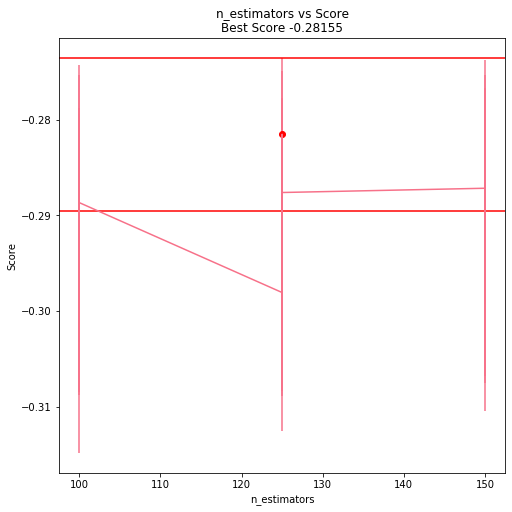

In [37]:
#Best Cost parameter
print('Best n_estimators parameter : '+ str(grid_tree_acc.best_estimator_.n_estimators))
print('Best learning_rate parameter : '+ str(grid_tree_acc.best_estimator_.learning_rate))
print('Best loss function : '+ str(grid_tree_acc.best_estimator_.loss))

# Report best Number of Neighbors
GridSearch_table_plot(grid_tree_acc, "n_estimators", negative=False, display_all_params=False)


In [38]:
gb = GradientBoostingRegressor(n_estimators=grid_tree_acc.best_estimator_.n_estimators,
                                   learning_rate=grid_tree_acc.best_estimator_.learning_rate,
                                   loss=grid_tree_acc.best_estimator_.loss)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

#Convert predictions and y values to original scale
gb_pred_orig = [math.exp(i) for i in gb_pred]
gb_test_orig = [math.exp(i) for i in y_test]

#Calculate mean squared error
score_gb = mean_squared_error(gb_test_orig, gb_pred_orig)
r2_gb = r2_score(gb_test_orig, gb_pred_orig)
print("\nGradient Boosting Regressor MSE: %.3f" % score_gb)
print("\nGradient Boosting Regressor R-squared: %.3f" % r2_gb)


Gradient Boosting Regressor MSE: 148614117675.378

Gradient Boosting Regressor R-squared: 0.574


### Building an Ensemble 

I will move on to selecting the best parameters for other algorithms. After that, I will build an ensemble using all the tuned variables.

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best n_estimators parameter : 125
Best max_depth parameter : 10
best parameters: {'max_depth': 10, 'n_estimators': 125}
best score:      -0.28791 (+/-0.00968)


,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,10,125,"{'max_depth': 10, 'n_estimators': 125}",-0.277218,-0.298280,-0.282297,-0.300804,-0.280948,-0.287910,0.009676,1
3,10,75,"{'max_depth': 10, 'n_estimators': 75}",-0.278803,-0.298788,-0.283416,-0.299309,-0.280521,-0.288168,0.009007,2
4,10,100,"{'max_depth': 10, 'n_estimators': 100}",-0.278949,-0.298339,-0.282971,-0.299375,-0.281704,-0.288268,0.008750,3
8,20,125,"{'max_depth': 20, 'n_estimators': 125}",-0.285892,-0.298358,-0.291711,-0.303017,-0.287772,-0.293350,0.006449,4
7,20,100,"{'max_depth': 20, 'n_estimators': 100}",-0.285308,-0.300476,-0.291271,-0.305266,-0.285944,-0.293653,0.007952,5
6,20,75,"{'max_depth': 20, 'n_estimators': 75}",-0.289002,-0.300119,-0.291641,-0.304287,-0.285945,-0.294199,0.006906,6
2,5,125,"{'max_depth': 5, 'n_estimators': 125}",-0.306546,-0.338147,-0.310644,-0.333372,-0.315597,-0.320861,0.012589,7
1,5,100,"{'max_depth': 5, 'n_estimators': 100}",-0.306361,-0.338493,-0.310987,-0.333569,-0.316164,-0.321115,0.012664,8
0,5,75,"{'max_depth': 5, 'n_estimators': 75}",-0.306525,-0.338704,-0.311236,-0.334480,-0.315104,-0.321210,0.012920,9


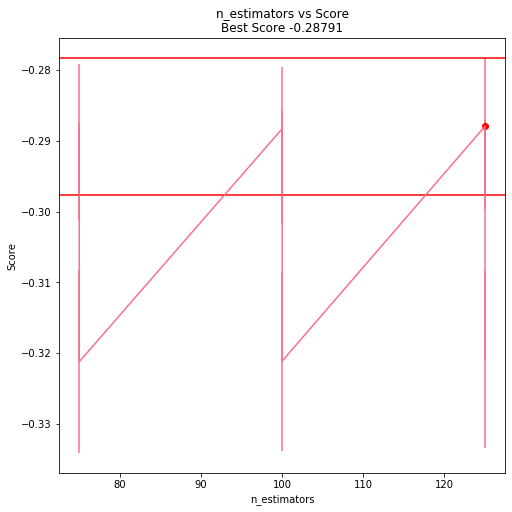

In [45]:
MyForest = RandomForestRegressor()
grid_values = {'n_estimators':[75, 100, 125],
               'max_depth':[5, 10, 20]}
grid_forest_acc = GridSearchCV(MyForest, param_grid = grid_values,scoring = 'neg_mean_squared_error', cv=5, n_jobs = -2)
grid_forest_acc.fit(X_train, y_train)

#Best Cost parameter
print('Best n_estimators parameter : '+ str(grid_forest_acc.best_estimator_.n_estimators))
print('Best max_depth parameter : '+ str(grid_forest_acc.best_estimator_.max_depth))

# Report best Number of Neighbors
GridSearch_table_plot(grid_forest_acc, "n_estimators", negative=False, display_all_params=False)

Best kernel : rbf
Best Cost parameter : 1
best parameters: {'C': 1, 'epsilon': 0.5, 'gamma': 0.05, 'kernel': 'rbf'}
best score:      -0.30056 (+/-0.00897)


,param_C,param_epsilon,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
24,1,0.5,0.05,rbf,"{'C': 1, 'epsilon': 0.5, 'gamma': 0.05, 'kerne...",-0.291294,-0.313538,-0.296051,-0.308924,-0.292975,-0.300557,0.008968,1
18,1,0.1,0.05,rbf,"{'C': 1, 'epsilon': 0.1, 'gamma': 0.05, 'kerne...",-0.298390,-0.320736,-0.299854,-0.317132,-0.299502,-0.307123,0.009723,2
42,10,0.5,0.05,rbf,"{'C': 10, 'epsilon': 0.5, 'gamma': 0.05, 'kern...",-0.297187,-0.318898,-0.305580,-0.316058,-0.300293,-0.307603,0.008545,3
26,1,0.5,0.1,rbf,"{'C': 1, 'epsilon': 0.5, 'gamma': 0.1, 'kernel...",-0.298188,-0.323093,-0.307759,-0.316550,-0.297679,-0.308654,0.010016,4
20,1,0.1,0.1,rbf,"{'C': 1, 'epsilon': 0.1, 'gamma': 0.1, 'kernel...",-0.306128,-0.329003,-0.308323,-0.322291,-0.302659,-0.313681,0.010160,5
36,10,0.1,0.05,rbf,"{'C': 10, 'epsilon': 0.1, 'gamma': 0.05, 'kern...",-0.310629,-0.328388,-0.310178,-0.323155,-0.309112,-0.316293,0.007930,6
6,0.1,0.5,0.05,rbf,"{'C': 0.1, 'epsilon': 0.5, 'gamma': 0.05, 'ker...",-0.306528,-0.333584,-0.313957,-0.326468,-0.309318,-0.317971,0.010372,7
0,0.1,0.1,0.05,rbf,"{'C': 0.1, 'epsilon': 0.1, 'gamma': 0.05, 'ker...",-0.310004,-0.338822,-0.313434,-0.330940,-0.311912,-0.321023,0.011638,8
44,10,0.5,0.1,rbf,"{'C': 10, 'epsilon': 0.5, 'gamma': 0.1, 'kerne...",-0.316250,-0.335779,-0.325774,-0.331266,-0.312455,-0.324305,0.008804,9
28,1,0.5,0.2,rbf,"{'C': 1, 'epsilon': 0.5, 'gamma': 0.2, 'kernel...",-0.319031,-0.347667,-0.334941,-0.334799,-0.315583,-0.330405,0.011721,10


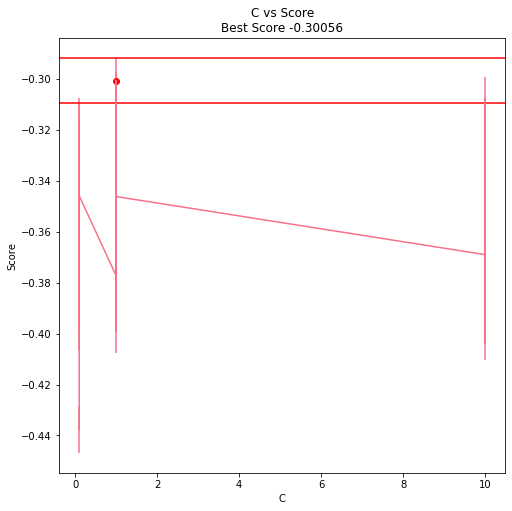

In [40]:
#Grid Search CV for SVR

MySvr = SVR()
grid_values = {'kernel':['rbf','linear'],
               'C':[0.1,1,10], 
               'gamma':[0.05, 0.1, 0.2],
               'epsilon':[0.1,0.5,1]}
grid_svr_acc = GridSearchCV(MySvr, param_grid = grid_values,scoring = 'neg_mean_squared_error', cv=5,n_jobs=-1)
grid_svr_acc.fit(X_train, y_train)

#Best parameters
print('Best kernel : '+ str(grid_svr_acc.best_estimator_.kernel))
print('Best Cost parameter : '+ str(grid_svr_acc.best_estimator_.C))

# Report best Number of Neighbors
GridSearch_table_plot(grid_svr_acc, "C", negative=False, display_all_params=False)

Best n_neighbors : 20
Best weights parameter : uniform
best parameters: {'n_neighbors': 20, 'weights': 'uniform'}
best score:      -0.32394 (+/-0.00930)


,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,20,uniform,"{'n_neighbors': 20, 'weights': 'uniform'}",-0.312095,-0.333512,-0.321438,-0.335907,-0.316768,-0.323944,0.009304,1
5,20,distance,"{'n_neighbors': 20, 'weights': 'distance'}",-0.317205,-0.332510,-0.324566,-0.341664,-0.316810,-0.326551,0.009488,2
2,10,uniform,"{'n_neighbors': 10, 'weights': 'uniform'}",-0.322288,-0.337479,-0.326858,-0.344848,-0.320498,-0.330394,0.009330,3
3,10,distance,"{'n_neighbors': 10, 'weights': 'distance'}",-0.331471,-0.341861,-0.335462,-0.355406,-0.325468,-0.337934,0.010237,4
0,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",-0.344392,-0.354616,-0.343707,-0.370250,-0.334857,-0.349565,0.012089,5
1,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",-0.358097,-0.364042,-0.358281,-0.382886,-0.346624,-0.361987,0.011881,6


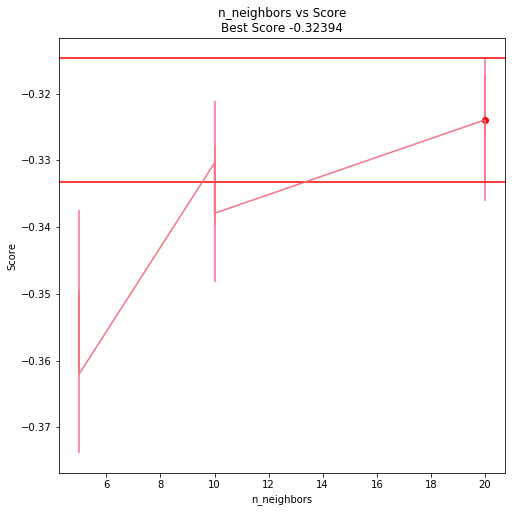

In [41]:
#Grid Search CV for KNN

MyKNN = KNeighborsRegressor()
grid_values = {'n_neighbors':[5,10,20],
               'weights':['uniform','distance']}
grid_knn_acc = GridSearchCV(MyKNN, param_grid = grid_values,scoring = 'neg_mean_squared_error', cv=5,n_jobs=-1)
grid_knn_acc.fit(X_train, y_train)

#Best parameters
print('Best n_neighbors : '+ str(grid_knn_acc.best_estimator_.n_neighbors))
print('Best weights parameter : '+ str(grid_knn_acc.best_estimator_.weights))

# Report best Number of Neighbors
GridSearch_table_plot(grid_knn_acc, "n_neighbors", negative=False, display_all_params=False)

In [42]:
#Building the meta-learner

def get_models():
    #Generate a library of simple learners
    svr = SVR(kernel=grid_svr_acc.best_estimator_.kernel,
              C=grid_svr_acc.best_estimator_.C,
              gamma=grid_svr_acc.best_estimator_.gamma,
              epsilon=grid_svr_acc.best_estimator_.epsilon)
    knn = KNeighborsRegressor(n_neighbors=grid_knn_acc.best_estimator_.n_neighbors,
                              weights=grid_knn_acc.best_estimator_.weights)
    lr = LinearRegression()
    rf = RandomForestRegressor(n_estimators=grid_forest_acc.best_estimator_.n_estimators, 
                               max_depth=grid_forest_acc.best_estimator_.max_depth)
    gb = GradientBoostingRegressor(n_estimators=grid_tree_acc.best_estimator_.n_estimators,
                                   learning_rate=grid_tree_acc.best_estimator_.learning_rate,
                                   loss=grid_tree_acc.best_estimator_.loss)

    models = {'svm': svr,
              'knn': knn,
              'random forest': rf,
              'gradient boosting': gb,
              'linear': lr,
              }

    return models

models = get_models()

meta_learner = ExtraTreesRegressor(
    n_estimators=50,
    criterion='mse',
    bootstrap=True,
    max_features=0.7,
    random_state=SEED)

# Instantiate the ensemble with 5 folds (stacking meta-learner)
sl = SuperLearner(
    folds=5,
    random_state=SEED,
    verbose=2,
    backend='multiprocessing'
)

# Add the base learners and the meta learner
sl.add(list(models.values()))
sl.add_meta(meta_learner)

# Train the ensemble
sl.fit(X_train, y_train)

#Get predictions for the test set
p_sl = sl.predict(X_test)


Fitting 2 layers
Processing layer-1             done | 00:00:21
Processing layer-2             done | 00:00:01
Fit complete                        | 00:00:23

Predicting 2 layers
Processing layer-1             done | 00:00:01
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:02


## Step 5: Assess expected accuracy

In [49]:
#Convert predictions and y values to original scale
y_pred_orig = [math.exp(i) for i in p_sl]
y_test_orig = [math.exp(i) for i in y_test]

#Calculate mean squared error
scoreStackXtres=mean_squared_error(y_test_orig, y_pred_orig)
r2_StackXtres = r2_score(y_test_orig, y_pred_orig)
print("\nSuper Learner MSE: %.3f" % scoreStackXtres)
print("\nSuper Learner R-squared: %.3f" % r2_StackXtres)


Super Learner MSE: 151796078839.362

Super Learner R-squared: 0.565


## Step 6: Assess variable importance

Feature importance cannot be assessed on the super learner. Nonetheless, it can be assessed on the Gradient Boosting Regression, which could give a good approximation of the feature importance in the super learner. 

In [55]:
importance = gb.feature_importances_
important_features = pd.Series(data=importance/importance.max() ,index=features)
important_10 = important_features.sort_values(ascending=False)[:10]

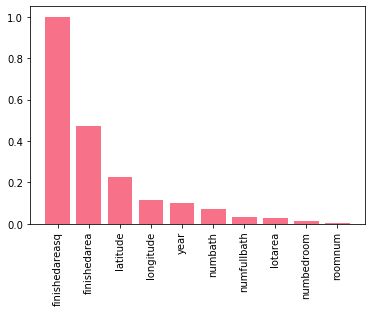

In [64]:
fig, axs = plt.subplots(figsize=(6,4))
axs.bar(range(len(important_10)), important_10, tick_label = important_10.keys())
plt.setp(axs.get_xticklabels(), fontsize=10, rotation='vertical')
plt.show()

Here we can see that finishedarea is a very important variable, since 'finishedarea' and 'finishedareasq' are the most important features. 

## Step 7: Prepare code to run and check performance of you model using a new input data with same exact format

First, dump the model and the key items like imputers and binary encoders.

In [81]:
filename = 'Model.sav'
pickle.dump((predummy_features, my_estimator1, cont_imputer, my_estimator2, cat_imputer, city_encoder, heating_encoder, features, scaler, sl), open(filename, 'wb'))


Now, I will load the model from disk and use it to assess the model on the test set. 

In [82]:
predummy_features, my_estimator1, cont_imputer, my_estimator2, cat_imputer, city_encoder, heating_encoder, features, scaler, sl = pickle.load(open(filename, 'rb'))

In [83]:
#Load data
test = pd.read_csv("./Data/Regression_Supervised_Test_1_reduced.csv")
predummy_test = test[predummy_features]

In [84]:
#Impute
test2 = predummy_test.copy()
test2 = test2.drop(col_impute_class, axis=1)
columns_without_classimp = test2.columns
test2 = cont_imputer.transform(test2)

test3 = pd.concat([pd.DataFrame(test2[:,:11]), predummy_test[col_impute_class]], axis=1)

test3 = cat_imputer.transform(test3)
test4 = pd.DataFrame(test3[:,:14])
col_titles = list(columns_without_classimp) + col_impute_class
test4.columns = col_titles

In [85]:
#Handle categorical variables and transform some variables
X_pretest = test4
y_test = test["parcelvalue"]

dummy_cols = ['citycode','countycode','heatingtype']

for col in dummy_cols:
    X_pretest[col] = X_pretest[col].astype(str)
    
X_pretest = pd.concat([X_pretest, city_encoder.transform(X_pretest['citycode'])], axis=1)
X_pretest = pd.concat([X_pretest, heating_encoder.transform(X_pretest['heatingtype'])], axis=1)
X_pretest = pd.concat([X_pretest, pd.get_dummies(X_pretest['countycode'], drop_first=True, prefix='county')], axis=1)

#Add terms that are more relevant
X_pretest['finishedareasq'] = X_pretest['finishedarea']**2

X_pretest = X_pretest.drop(dummy_cols, axis=1)

#Apply log to y to reduce skewness
y_test = pd.Series([math.log(i) for i in y_test])

In [86]:
#Select features in my model and scale variables
X_pretest = X_pretest[features]
X_test = pd.DataFrame(scaler.transform(X_pretest))

In [87]:
#Predictions
y_pred = sl.predict(X_test)

#Convert predictions and y values to original scale
y_pred_orig = [math.exp(i) for i in y_pred]
y_test_orig = [math.exp(i) for i in y_test]

#Calculate mean squared error
scoreStackXtres=mean_squared_error(y_test_orig, y_pred_orig)
r2_StackXtres = r2_score(y_test_orig, y_pred_orig)
print("\nSuper Learner MSE: %.3f" % scoreStackXtres)
print("\nSuper Learner R-squared: %.3f" % r2_StackXtres)


Predicting 2 layers
Processing layer-1             done | 00:00:03
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:04

Super Learner MSE: 197422634237.159

Super Learner R-squared: 0.583


Therefore, the model performs slightly worse on a test set, getting a higher MSE. However, note that the R-squared score is higher in this case. 